In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tqdm
import timeit
import textwrap
import sklearn
import xgboost
import unittest

from scipy import stats
from scipy.stats import zscore
from scipy.stats import skew
from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
path = 'C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive/*.csv'
input_files = glob.glob(path)

In [3]:
def file_load(path, input_files):
        
    for i, file in enumerate(input_files):
        print(file)
        globals()[f'df{i+1}'] = pd.read_csv(input_files[i])
    print(f'Total number of files loaded: {len(input_files)}')
    df_store = [eval(f'df{i+1}') for i in range(len(input_files))]   # Dataframe preperation
    return df_store
    
file_load(path, input_files)[0]

C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive\uber.csv
Total number of files loaded: 1


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [4]:
df_store = [eval(f'df{i+1}') for i in range(len(input_files))]   # Dataframe preperation

In [5]:
class Dataset:
    def __init__(self, data, threshold):
        self.data = data
        self.threshold = threshold
    
    def data_transform(self):
        self.data['pickup_datetime'] = pd.to_datetime(self.data['pickup_datetime']).dt.tz_localize(None)
        self.data['pickup_datetime'] = self.data['pickup_datetime'].dt.floor('H')
        
        self.data['Label_Hour'] = self.data['pickup_datetime'].dt.hour
        self.data['Label_Date'] = self.data['pickup_datetime'].dt.date

        self.data['day_name'] = pd.to_datetime(self.data['pickup_datetime']).dt.day_name()
        self.data['day_of_the_week'] = pd.to_datetime(self.data['pickup_datetime']).dt.weekday
        return self.data
            
    def data_remove_outliers(self):
        self.data = self.data[(np.abs(stats.zscore(self.data['passenger_count'])) < 2)]
        self.data = self.data[(np.abs(stats.zscore(self.data['fare_amount'])) < 2)]
        return self.data

    def data_clean(self):
        self.data['fare_amount'] = abs(self.data.fare_amount)
        self.data.passenger_count.replace(0, 1, inplace=True)
        self.data.fare_amount.replace(0, 1, inplace=True)
        self.data = self.data.dropna()
        return self.data
    
    def winsorization(self):
        median = self.data['sPED'].median()
        lower_quantile = self.data['sPED'].quantile(self.threshold)
        upper_quantile = self.data['sPED'].quantile(1-self.threshold)
        self.data['sPED'][self.data['sPED'] < lower_quantile] = -1*median
        self.data['sPED'][self.data['sPED'] > upper_quantile] = median
        return self.data
    
    def index_set(self):
        self.data = self.data.set_index('pickup_datetime')
        self.data.index = self.data.index.strftime('%Y-%m-%d-%H')
        return self.data

class GroupClass:
    def __init__(self, data, col_group):
        self.data = data
        self.col_group = col_group
    
    def group_by_hour(self, col_group):
        self.data = self.data[col_group].groupby(['pickup_datetime'])['passenger_count','fare_amount'].agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()
        return self.data
    
    def group_by_day(self, col_group):
        self.data = self.data[col_group].groupby(['Label_Date'])['passenger_count','fare_amount'].agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()
        return self.data
    
class FeatureExtraction:
    def __init__(self, data, col_feature, n_window):
        self.data = data
        self.col_feature = col_feature
        self.n_window = n_window

    def calc_pct_change(self, col_feature):
        for col in col_feature:
            self.data[col + '_pct_change'] = self.data[col].pct_change()
        return self.data
    
    def calc_sma(self, col, n_window):
        self.data[col + '_sma'] = self.data[col].rolling(window=self.n_window).mean()
        return self.data
        
    def calc_ema(self, col, n_window):
        self.data[col + '_ema'] = self.data[col].ewm(span=n_window, adjust=False).mean()
        return self.data
        
    def calc_sma_PED(self):
        self.data['sPED'] = self.data.passenger_count_pct_change_sma / self.data.fare_amount_pct_change_sma
        return self.data
        
    def calc_ema_PED(self):
        self.data['ePED'] = self.data.passenger_count_pct_change_ema / self.data.fare_amount_pct_change_ema
        return self.data

class ModelSelection:
    def __init__(self, data, input_columns, target_column, cv_splits, test_split):
        self.data = data
        self.input_columns = input_columns
        self.target_column = target_column
        self.cv_splits = cv_splits
        self.test_split = test_split
        # self.models = [DecisionTreeRegressor(random_state=0), LinearRegression(),
        #                RandomForestRegressor(), 
        #                SVR(C=1.0, epsilon=0.2), 
        #                xgboost.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=1-test_split)]
        self.models = {
            'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
            'LinearRegression': LinearRegression(),
            'RandomForestRegressor': RandomForestRegressor(), 
            'SVR': SVR(C=1.0, epsilon=0.2), 
            'XGBRegressor': xgboost.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=1-test_split)
        }
        
    def split_dataset(self):
        input_features = self.data.drop(input_columns, axis=1)
        target_variable = self.data[target_column]
        X_train, X_test, y_train, y_test = train_test_split(input_features, target_variable, shuffle=False, test_size=test_split)
        return X_train, X_test, y_train, y_test
    
    def model_evaluation(self, model, X_train, y_train, cv_splits):
        std_clf = make_pipeline(StandardScaler(), model)

        r2_scores = []
        mae_scores = []
        rmse_scores = []

        kf = KFold(n_splits=cv_splits, shuffle=False)
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

            std_clf.fit(X_train_cv, y_train_cv)
            y_pred = std_clf.predict(X_test_cv)

            r2_scores.append(r2_score(y_test_cv, y_pred))
            mae_scores.append(mean_absolute_error(y_test_cv, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred)))

        return {"Mean R^2": sum(r2_scores) / cv_splits, 
                "Mean MAE": sum(mae_scores) / cv_splits,
                "Mean RMSE": sum(rmse_scores) / cv_splits}
        
    def run_model_evaluation(self):
        X_train, X_test, y_train, y_test = self.split_dataset()
        results = {}
        for model_name, model in self.models.items():
            results[model_name] = self.model_evaluation(model, X_train, y_train, cv_splits)
        return results
    
    def select_initial_model(self):
        X_train, X_test, y_train, y_test = self.split_dataset()
        best_model = None
        best_score = 0
        for model_name, model in self.models.items():
            # Define hyperparameters for grid search
            if model_name == 'DecisionTreeRegressor':
                params = {'max_depth': [5, 10, 15]}
            elif model_name == 'LinearRegression':
                params = {'fit_intercept': [True, False]}
            elif model_name == 'RandomForestRegressor':
                params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
            elif model_name == 'SVR':
                params = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
            elif model_name == 'XGBRegressor':
                params = {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
                
            # Perform grid search
            grid = GridSearchCV(estimator=model, param_grid=params, cv=self.cv_splits, n_jobs=-1)
            grid.fit(X_train, y_train)
            
            # Determine if this model is the best so far
            if grid.best_score_ > best_score:
                best_score = grid.best_score_
                best_model = grid.best_estimator_
                best_params = grid.best_params_
        
        best_model_name = type(best_model).__name__
        if best_model_name == 'XGBRegressor':
            model_class = xgboost.XGBRegressor
        else:
            model_class = getattr(sklearn.ensemble, best_model_name)
        selected_model = model_class(**best_params)
        
        print('\n')
        print("Selected model: {}".format(type(best_model).__name__))
        print("Hyperparameters: {}".format(best_params))
        print("Model score: {}".format(best_score))
        print('\n')

        return selected_model
            
class Model:
    def __init__(self, data, X_train, y_train, selected_model, cv_splits):
        self.data = data
        self.X_train = X_train
        self.y_train = y_train
        self.selected_model = selected_model
        self.cv_splits = cv_splits

    def train_model(self):
        std_clf = make_pipeline(StandardScaler(), self.selected_model)
        std_clf.fit(X_train_cv, y_train_cv)
        self.std_clf = std_clf

        kf = KFold(n_splits=self.cv_splits, shuffle=False)
        train_results = []
        
        for train_index, test_index in kf.split(kf.split(self.X_train)):
            X_train_cv, X_test_cv = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_cv, y_test_cv = self.y_train.iloc[train_index], self.y_train.iloc[test_index] 
            apply = self.std_clf.score(X_train_cv, y_train_cv)
            train_results.append(apply)
        
        self.train_results = train_results
        return self.std_clf, self.train_scores, kf

    def cv_model(self):
        y_pred_train = cross_val_predict(self.std_clf, self.X_train, self.y_train, cv=self.kf)
        
        r2 = r2_score(self.y_train, y_pred_train)
        mae = mean_absolute_error(self.y_train, y_pred_train)
        rmse = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
        
        cv_metrics = {'Initial_Model': self.selected_model,
              "Mean R^2": r2, 
              "Mean MAE": mae,
              "Mean RMSE": rmse}
        return cv_metrics
    
    def validate_model(self, X_test, y_test):
        y_pred = self.std_clf.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        validation_metrics = {'Initial_Model': self.selected_model,
              "Mean R^2": r2, 
              "Mean MAE": mae,
              "Mean RMSE": rmse}
        return validation_metrics

    def test_model(self, X_test, y_test):
        y_pred = self.std_clf.predict(X_test)
        return y_pred
    
    def visualize_results(self, X_test, y_test, y_pred):
        fig, ax = plt.subplots(1, 1, figsize=(32, 10))
        plt.plot(y_test)
        plt.plot(y_pred)
        plt.xlabel("Date time")
        plt.ylabel("Price Elasticity of Demand")
        plt.xticks(np.arange(0, len(y_test), 20), rotation='vertical')
        plt.show()

    def initial_model_metrics(self, X_test, y_test, y_pred):
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        initial_metrics = {'Initial_Model': self.selected_model,
              "Mean R^2": r2, 
              "Mean MAE": mae,
              "Mean RMSE": rmse}
        return initial_metrics

---

# **Initial Exploration**

In [6]:
keys_list = [df_store[i].keys() for i in range(len(df_store))]
flattened_list = [item for sublist in keys_list for item in sublist]
unique_keys = list(set(flattened_list))

print('Number of unique keys:', len(unique_keys))
# print(keys_list)
unique_keys

Number of unique keys: 9


['key',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_latitude',
 'dropoff_longitude',
 'Unnamed: 0',
 'fare_amount',
 'passenger_count']

In [7]:
df = df_store[0]
df0 = df_store[0]
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [8]:
df.describe().round()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.0,200000.0,200000.0,200000.0,199999.0,199999.0,200000.0
mean,27712504.0,11.0,-73.0,40.0,-73.0,40.0,2.0
std,16013822.0,10.0,11.0,8.0,13.0,7.0,1.0
min,1.0,-52.0,-1341.0,-74.0,-3357.0,-882.0,0.0
25%,13825346.0,6.0,-74.0,41.0,-74.0,41.0,1.0
50%,27745495.0,8.0,-74.0,41.0,-74.0,41.0,1.0
75%,41555301.0,12.0,-74.0,41.0,-74.0,41.0,2.0
max,55423567.0,499.0,57.0,1644.0,1154.0,873.0,208.0


In [9]:
# from sklearn.model_selection import StratifiedShuffleSplit

# X = df.drop('target_column', axis=1)
# y = df['target_column']

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, test_index in sss.split(X, y):
#     df_sample = df.iloc[test_index]

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 42.1 MB


In [11]:
memory_usage = df.memory_usage(deep=True)
print(memory_usage/1000000)

Index                 0.000128
Unnamed: 0            1.600000
key                  16.936069
fare_amount           1.600000
pickup_datetime      16.000000
pickup_longitude      1.600000
pickup_latitude       1.600000
dropoff_longitude     1.600000
dropoff_latitude      1.600000
passenger_count       1.600000
dtype: float64


In [12]:
df.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [13]:
for col in df:
  print(df[col].unique())

[24238194 27835199 44984355 ... 27804658 20259894 11951496]
['2015-05-07 19:52:06.0000003' '2009-07-17 20:04:56.0000002'
 '2009-08-24 21:45:00.00000061' ... '2009-06-29 00:42:00.00000078'
 '2015-05-20 14:56:25.0000004' '2010-05-15 04:08:00.00000076']
[ 7.5   7.7  12.9  ... 37.2  86.25 89.1 ]
['2015-05-07 19:52:06 UTC' '2009-07-17 20:04:56 UTC'
 '2009-08-24 21:45:00 UTC' ... '2009-06-29 00:42:00 UTC'
 '2015-05-20 14:56:25 UTC' '2010-05-15 04:08:00 UTC']
[-73.99981689 -73.994355   -74.005043   ... -73.969204   -74.003548
 -73.99712372]
[40.73835373 40.728225   40.74077    ... 40.74391937 40.72121
 40.72545242]
[-73.99951172 -73.99471    -73.962565   ... -73.95223999 -74.01390839
 -73.858957  ]
[40.72321701 40.750325   40.772647   ... 40.692588   40.6954155
 40.768793  ]
[  1   3   5   2   4   6   0 208]


In [14]:
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col}: {dtype}")

Unnamed: 0: int64
key: object
fare_amount: float64
pickup_datetime: object
pickup_longitude: float64
pickup_latitude: float64
dropoff_longitude: float64
dropoff_latitude: float64
passenger_count: int64


In [15]:
count = df['passenger_count'].eq(208).sum()
count

1

In [16]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [17]:
df = df[['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime','passenger_count']]
df

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,5
...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,1


---

In [18]:
frac = 0.01
df_frac = len(df)*frac
df = df.iloc[:int(df_frac),:]
df0 = df0.iloc[:int(df_frac),:]

df

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,5
...,...,...,...,...,...
1995,1471595,2012-03-16 21:00:35.0000006,8.5,2012-03-16 21:00:35 UTC,1
1996,15828110,2011-03-25 12:27:38.0000001,13.7,2011-03-25 12:27:38 UTC,1
1997,41730233,2011-05-14 02:24:00.000000184,7.3,2011-05-14 02:24:00 UTC,2
1998,6544585,2010-02-22 07:32:01.0000002,3.7,2010-02-22 07:32:01 UTC,2


In [19]:
#data_remove_outliers(df)

In [20]:
#raw_data

In [21]:
#len(data_remove_outliers(df)) / len(raw_data)

In [22]:
class InspectData:
    def __init__(self, raw_data, data, expected_dtypes, processed_dtypes, inspect_cols, eng_feature_cols, tagret_col):
        self.raw_data = raw_data
        self.data = data
        self.expected_dtypes = expected_dtypes
        self.processed_dtypes = processed_dtypes
        self.inspect_cols = inspect_cols
        self.eng_feature_cols = eng_feature_cols
        self.target_col = target_col
    
    def inspection_1(self):
        # BEFORE PREPROCESSING
        
        # Test 1: Ensure data is not empty
        if self.data.empty:
            raise ValueError('Inspection_1 Part 1 FAILURE: Input data is empty')
        else:
            print('Inspection_1 Part 1 PASS: Input data is not empty')

        # Test 2: Check for missing values
        if self.data.isnull().values.any():
            return "Inspection_1 Part 2 FAILURE: Input data contains missing values"
        else:
            print('Inspection_1 Part 2 PASS: Data has no missing values')
        
        # Test 3: Check for NaN values    
        if self.data.isna().values.any():
            return "Inspection_1 Part 3 FAILURE: Input data contains NaN values"
        else:
            print('Inspection_1 Part 3 PASS: Data has no NaN values')
        
        # Test 4: Check for duplicate rows
        if self.data.duplicated().any():
            return "Inspection_1 Part 4 CAUTION: Input data contains duplicate rows"
        else:
            print("Inspection_1 Part 4 PASS: No duplicate rows found")
            
        # Test 5: Ensure data types are as expected
        mismatched_columns = []
        for col, dtype in self.expected_dtypes.items():
            if self.data[col].dtype != dtype:
                mismatched_columns.append((col, self.data[col].dtype, dtype))
        
        if mismatched_columns:
            column_info = '\n'.join([f"{col}: expected {expected}, got {actual}" for col, actual, expected in mismatched_columns])
            raise ValueError(f"Inspection_1 Part 5 FAILURE: Columns {column_info}. Unexpected data types.")
        else:
            print('Inspection_1 Part 5 PASS: All columns have expected data types')

        outlier_cols = []
        for col in self.inspect_cols:
            z_score = np.abs((self.data[col] - self.data[col].mean()) / self.data[col].std())
            if z_score.max() > 3:
                outlier_cols.append(col)
        if outlier_cols:
            print(f"Inspection_1 Part 6 CAUTION: Columns {outlier_cols} contain outliers")
        else:
            print("Inspection_1 Part 6 PASS: No columns have outliers")



    
    def inspection_2(self):
        
        # Test 1: Outlier analysis
        length_raw_data = len(self.raw_data)
        length_data = len(self.data)
        perc_change = length_data / length_raw_data
        
        if length_raw_data == length_data:
            return print('Inspection_2 Part 1 FAILURE: Outliers have not been removed')
        else:
            print(f'Inspection_2 Part 1 PASS: Outliers removed, resultant dataset at {perc_change*100}%.')
            
        # Test 2: Check for missing values
        if self.data.isnull().values.any():
            return "Inspection_2 Part 2 FAILURE: Input data contains missing values"
        else:
            print('Inspection_2 Part 2 PASS: Data has no missing values')
        
        # Test 3: Check for NaN values    
        if self.data.isna().values.any():
            return "Inspection_2 Part 3 FAILURE: Input data contains NaN values"
        else:
            print('Inspection_2 Part 3 PASS: Data has no NaN values')
        
        # Test 4: Check for duplicate rows
        if self.data.duplicated().any():
            return "Inspection_2 Part 4 CAUTION: Input data contains duplicate rows"
        else:
            print("Inspection_2 Part 4 PASS: No duplicate rows found")
        
        # Test 5: Check processed column dtypes are as expected
        mismatched_columns = []
        for col, dtype in self.processed_dtypes.items():
            if self.data[col].dtype != dtype:
                mismatched_columns.append((col, self.data[col].dtype, dtype))
        
        if mismatched_columns:
            column_info = '\n'.join([f"{col}: expected {expected}, got {actual}" for col, actual, expected in mismatched_columns])
            raise ValueError(f"Inspection_2 Part 2 FAILURE: Columns {column_info}. Unexpected data types.")
        else:
            print('Inspection_2 Part 5 PASS: All columns have expected data types')
        
    
    def data_inspection(self):
        # Post feature engineering
        
        # # Test 1: Check fold metrics for bias
        # mae_threshold = 2 * np.mean(cv_metrics['MAE per Fold'])
        # mse_threshold = 2 * np.mean(cv_metrics['MSE per Fold'])
        
        # for i, mae in enumerate(cv_metrics['MAE per Fold']):
        #     if abs(mae) > mae_threshold:
        #         print(f"CAUTION: MAE for fold {i+1} is {mae}, above the threshold of {mae_threshold}")

        # for i, mse in enumerate(cv_metrics['MSE per Fold']):
        #     if abs(mse) > mse_threshold:
        #         print(f"CAUTION: MSE for fold {i+1} is {mse}, above the threshold of {mse_threshold}")
        
        # Test 1: Check engineered features have adequate correlation to target
        corr_threshold = 0.1
        correlations = {}
        for col in self.eng_feature_cols:
            corr = self.data[col].corr(self.data[self.target_col])
            correlations[col] = corr
            
        below_threshold = [col for col, corr in correlations.items() if corr < corr_threshold]
        
        if below_threshold:
            print(f"Inspection Part 1 CAUTION: The following columns have a correlation below {corr_threshold} with the target variable:")
            for col in below_threshold:
                print(f"         {col}, {correlations[col]}")
        else:
            print("Inspection Part 1 PASS: All feature columns meet the correlation threshold.")
            
        # Test 2: Check for skewness in data
        skew_threshold = 1

        for col in self.eng_feature_cols:
            col_skew = skew(self.data[col])
            if abs(col_skew) > skew_threshold:
                print(f"Inspection Part 2 CAUTION: The {col} column is highly skewed (skewness = {col_skew:.2f}).")
            else:
                print('Inspection Part 2 PASS: All feature columns have low skew')
                
        # Test 1: Outlier analysis
        length_raw_data = len(self.raw_data)
        length_data = len(self.data)
        perc_change = length_data / length_raw_data
        
        if length_raw_data == length_data:
            return print('Inspection Part 3 FAILURE: Outliers have not been removed')
        else:
            print(f'Inspection Part 3 PASS: Outliers removed, resultant dataset at {perc_change*100}%.')

In [23]:
raw_data = df0
data = df

expected_dtypes = {
    'key': object,
    'fare_amount': float,
    'pickup_datetime': object,
    'passenger_count': np.int64
    }

processed_dtypes = {
    'key': object,
    'fare_amount': float,
    'pickup_datetime': 'datetime64[ns]',
    'passenger_count': np.int64,
    'Label_Hour': np.int64,
    'Label_Date': object,
    'day_name': object,
    'day_of_the_week': np.int64
    }

inspect_cols = [
    'passenger_count', 
    'fare_amount'
    ]

col_group = ['pickup_datetime', 'fare_amount', 'passenger_count','Label_Date']   # Group by columns
col_feature = ['fare_amount', 'passenger_count']   # Feature extraction columns
input_columns = ['sPED']
target_col = 'sPED'

eng_feature_cols = ['fare_amount_pct_change', 'passenger_count_pct_change', 
                    'passenger_count_pct_change_sma', 'fare_amount_pct_change_sma'
                    ]

n_window = 3
threshold = 0.05

In [24]:
def pipeline(raw_data, data, 
             expected_dtypes, processed_dtypes,
             inspect_cols, 
             eng_feature_cols, target_col,
             threshold,
             col_feature, n_window,
             col_group, group_by='hour'):
    
    print('Initialising Pipeline...')
    
    print('\nInspecting Raw data...')
    inspect = InspectData(raw_data, data, expected_dtypes, processed_dtypes, inspect_cols, eng_feature_cols, target_col)
    layer_1_inspection = inspect.inspection_1()
    
    print('\nProcessing data...')
    dataset = Dataset(data, threshold=0.05)
    data = dataset.data_transform()
    data = dataset.data_remove_outliers()
    
    print('\nInspecting Processed Data...')
    inspect = InspectData(raw_data, data, expected_dtypes, processed_dtypes, inspect_cols, eng_feature_cols, target_col)
    layer_2_inspection = inspect.inspection_2()
    
    print('\nGrouping data...')
    group_class = GroupClass(data, col_group)
    if group_by == 'hour':
        data = group_class.group_by_hour(col_group)
    elif group_by == 'day':
        data = group_class.group_by_day(col_group)

    print('\nPerforming Feature Extraction...')
    feature_extraction = FeatureExtraction(data, col_feature, n_window)
    data = feature_extraction.calc_pct_change(col_feature)
    data = feature_extraction.calc_sma('passenger_count_pct_change', n_window)
    data = feature_extraction.calc_sma('fare_amount_pct_change', n_window)
    data = feature_extraction.calc_ema('passenger_count_pct_change', n_window)
    data = feature_extraction.calc_sma_PED()
    
    print('\nCleaning data...')
    dataset = Dataset(data, threshold)
    data = dataset.data_clean()
    data = dataset.index_set()
    data = dataset.winsorization()
    
    print('\nInspecting Data Post Feature Engineering...')
    inspect = InspectData(raw_data, data, expected_dtypes, processed_dtypes, inspect_cols, eng_feature_cols, target_col)
    layer_3_inspection = inspect.inspection_3()
    
    print('\nInitializing Model Selection Process...')
    model_select = ModelSelection(data, input_columns, target_column, cv_splits, test_split)
    X_train, X_test, y_train, y_test = model_select.split_dataset()
    compare_models = model_select.run_model_evaluation()
    selected_model = model_select.select_initial_model()

    return data

data_output = pipeline(raw_data, data, 
                       expected_dtypes, processed_dtypes,
                       inspect_cols, 
                       eng_feature_cols, target_col,
                       threshold,
                       col_feature, n_window,
                       col_group, group_by='hour')
data_output

Initialising Pipeline...

Inspecting Raw data...
Inspection_1 Part 1 PASS: Input data is not empty
Inspection_1 Part 2 PASS: Data has no missing values
Inspection_1 Part 3 PASS: Data has no NaN values
Inspection_1 Part 4 PASS: No duplicate rows found
Inspection_1 Part 5 PASS: All columns have expected data types
Inspection_1 Part 6 CAUTION: Columns ['passenger_count', 'fare_amount'] contain outliers

Processing data...

Inspecting Processed Data...
Inspection_2 Part 1 PASS: Outliers removed, resultant dataset at 86.5%.
Inspection_2 Part 2 PASS: Data has no missing values
Inspection_2 Part 3 PASS: Data has no NaN values
Inspection_2 Part 4 PASS: No duplicate rows found
Inspection_2 Part 5 PASS: All columns have expected data types

Grouping data...

Performing Feature Extraction...

Cleaning data...

Inspecting Data Post Feature Engineering...
Inspection_3 Part 1 CAUTION: The following columns have a correlation below 0.1 with the target variable:
         fare_amount_pct_change, 0.0069

NameError: name 'target_column' is not defined

In [ ]:
class TestData:
    def __init__(self, data, original_data, test_features, target_column):
        self.data = data
        self.original_data = original_data
        self.test_features = test_features
        self.target_column = target_column
    
    def test_dataset(self):
        try:
            # Test 1: Ensure data is not empty
            if self.data.empty:
                return "ERROR: Input data is empty"

            # Test 3: Check for missing values
            if self.data.isnull().values.any():
                return "ERROR: Input data contains missing values"
            
            outlier_cols = []
            for col in self.test_features:
                z_scores = np.abs(stats.zscore(self.data[col]))
                if np.max(z_scores) > 3:
                    outlier_cols.append(col)

            if outlier_cols:
                return f"ERROR: Input data contains outliers in columns {outlier_cols}"
            else:
                return "No outliers detected"

            # If all tests pass, return None
            return print('Initial Dataset Test Past')
        
        except Exception as e:
            return f"ERROR: {e}"

class DataValidator:
    
    def __init__(self, data, validate_columns):
        self.data = data
        self.validate_columns = validate_columns
        
    def check_empty_data(self):
        """
        Checks if the data is empty.
        """
        if self.data.empty:
            raise ValueError("Data is empty")
    
    def check_missing_values(self):
        """
        Checks if there are any missing values in the data.
        """
        if self.data.isnull().values.any():
            raise ValueError("Data contains missing values")
    
    def check_outliers(self):
        """
        Checks for outliers in a specified column of the data.
        """
        col = self.data[self.validate_columns]
        z_score = np.abs((col - col.mean()) / col.std())
        if z_score.max() > 3:
            raise ValueError(f"Column {self.validate_columns} contains outliers")
    
    def validate_data(self):
        """
        Runs all data validation checks.
        """
        self.check_empty_data()
        self.check_missing_values()
        self.check_outliers('col_name_1')
        self.check_outliers('col_name_2')
        # Add more checks as necessary


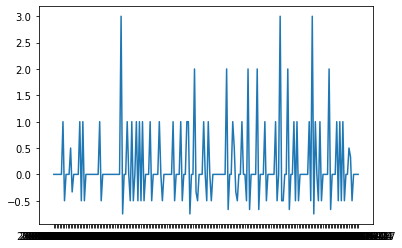

In [ ]:
plt.plot(data_output[0:200].passenger_count_pct_change)